# The Jaynes–Cummings model with Zeeman splitting
The Jaynes–Cummings model is the most basic model for an atom interacting with
light. The model requires very little computational power, but is quite
powerful, phenomenologically speaking. We start by writing down the Hamiltonian,
which expresses the total energy in the system,
$$\mathcal{H}_\text{JC} = \omega_c a^\dagger a + \frac{\Delta}{2} \sigma^z
    + g \left( a \sigma^+ + a^\dagger \sigma^- \right) \,.$$
Essentially, an atom in a state $\sigma^z$ interacts with an optical cavity
which a single frequency mode $\omega$—created by $a^\dagger$ and destroyed by
$a$—causing the atom to either absorb a photon and move to its excited state
($a \sigma^+$) or emit a photon and move to its ground state
($a^\dagger \sigma^-$).

<!--<div class="alert alert-block alert-info">-->
> Note two things: that $\hbar = 1$ in the Hamiltonian I've written
> down, and $a^\dagger a$ makes an integer. First, $\hbar$ is set to $1$ for
> convenience, since having to do things at $10^{-34} \text{J}\cdot\text{s}$
> would be annoying. Second, first part of the Jaynes–Cummings Hamiltonian is
> basically saying that "the amount of energy in the system is the frequency
> multiplied by a number," since a frequency multiplied by $\hbar$ just
> returns an energy value. (Am I making any sense?)
<!--</div>-->

To make a prototypical sensor, we then just need to make the Hamiltonian
reactive to something in the environment. In this case, we'll assume that the
atom has Zeeman splitting,
$$\mathcal{H} = \mathcal{H}_\text{JC} - \frac{\mu}{2} \mathbf{B} \cdot \mathbf{S} \,.$$
$\mathbf{S}$ is the total spin of the atom, which we can write as a vector
$\mathbf{S} = (S^x, S^y, S^z)$, where $S^x = \frac{1}{2} \sigma^x$, $S^y =
\frac{1}{2} \sigma^y$, and $S^z = \frac{1}{2} \sigma^z$.
If we assume that the magnetic field is homogenous—that is, the field is the
constant in the $x$-, $y$-, and $z$-directions, a reasonable approximation
given how tiny atoms are—we can write this Hamiltonian as
$$\mathcal{H} = \mathcal{H}_\text{JC} - \frac{\mu}{4} B \left( \sigma^x +
    \sigma^y + \sigma^z \right) \,.$$

# Setting the simulation up
First thing's first, we need to import all of the necessary libraries that will
be used in this notebook. We'll be using [QuTiP](https://qutip.org) to do all of
the quantum mechanical calculations, `numpy` for its speedy mathematical
capabilities, and `matplotlib` for its plots.

In [347]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from mpl_toolkits import mplot3d

# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')
%matplotlib inline

Now we need to define the system's operators. To make life easier, these are
created as global variables.

In [3]:
# set up system operators---sadly, these need to be global
a = tensor(qeye(2), destroy(N)) # cavity destruction operator
σm = tensor(sigmam(), qeye(N))  # atom state lowering operator
σz = tensor(sigmaz(), qeye(N))  # σm.dagger() * σm
σy = tensor(sigmay(), qeye(N))  #1j * (σm - σm.dag())
σx = tensor(sigmax(), qeye(N))  #(σm.dag() + σm)

These are the system parameters that we'll use for the simulation.

In [220]:
cavity_frequency = 1.0
atom_detuning    = 0.25
atom_cavity_coupling = 4.0
number_of_modes = 5
system_parameters = [cavity_frequency, atom_detuning, atom_cavity_coupling]

# time linspace
t_start = 0.
t_end   = 10.
number_of_times = 500 #10000
t = np.linspace(t_start, t_end, number_of_times)

Here we define the system's Hamiltonian using a few functions.

In [174]:
def jaynes_cummings(parameters):
    ω = parameters[0]
    Δ = 0.5 * parameters[1]
    g = parameters[2]
    
    H0 = ω * a.dag() * a + Δ * σz
    H1 = g * ( a.dag() * σm + a * σm.dag() )
    return H0 + H1


def zeeman_splitting(B): # assume a homogeneous magnetic field
    ge = -2 * 1.00115965218059 # electron's anomalous magnetic moment
    # Using a "real" gyromagnetic ratio makes the simulation act crazy since
    # 10^11 is a rather massive, nasty number.
    γ = -1.706
    μ = ge * γ
    Hz = -0.25 * μ * B * (σx + σy + σz)
    return Hz

def hamiltonian(parameters, B):
    return jaynes_cummings(parameters) + zeeman_splitting(B)

# Simulation using the Lindblad equation
Now, finally, we can set up a function to simulate the whole system. A function
is useful in this instance since I'm planning on simulating systems undergoing
various magnetic fields—rather than attempting to write code for *every single*
field imaginable, I can just write a function that does all of the simulations
for me.

Rather than using the classic Schrödinger equation, we'll use the Lindblad
equation since it is specially made for open quantum systems. The Lindblad
equation,
$$\frac{d\rho(t)}{dt} = -i[H, \rho] + \frac{1}{2} \sum_n
    \left( 2 J^\dagger_n \rho J_n
        - \left\{ J^\dagger_n J_n, \rho \right\}\right)\,.$$
The Lindblad equation solves for the *density matrix*, $\rho$—the density of
probabilities for different states of a system—rather than the wavefunction. The
$J_n$ operator factors in some kind of process in the environment, such as a
photon randomly being injected to the system or something like that. For our
purposes, I'm modeling the atom being relaxed with $J_1 = \gamma_1^{1/2}
\sigma^-$, and a photon being randomly destroyed or created with $J_2 =
\gamma_2^{1/2} a$ and $J_3 = \gamma_3^{1/2} a^\dagger$, respectively.

>The two parts of the equation with brackets, $[H, \rho] = H \rho - \rho H$ and
> $\left\{ J^\dagger_n J_n, \rho \right\} = J^\dagger_n J_n \rho +
 \rho J^\dagger_n J_n$ are the *commutator* and
> *anticommutator*, respectively. These work because of the fact that
> operators are, fundamentally, matrices—and matrix multiplication is, in
> general, noncommutative.

We can then extract *correlation functions* from the Lindblad equation using
a lot of math I'm too lazy to write down here. Luckily, QuTiP does all the
work for us. In general, we're interested in one function,
$\langle a^\dagger(\omega_0 + d\omega) a(\omega_0) \rangle$, which is the
emission spectrum for the system. Since we can't measure an atom's state
directly, but we *can* measure the light going in and out of the system, this
functions as the emission spectrum as the "readout" for our system.

In [227]:
def simulate_system(t,                         # np linspace
                    system_parameters,         # list of floats
                    noise_parameters,          # list of floats
                    magnetic_field,            # float
                    N,                         # int
                    initial_cavity_state = 1,  # int
                    initial_atom_state   = 0): # int

    # set up noise operators
    spin_relaxation   = np.sqrt(noise_parameters[0]) * σm
    cavity_relaxation = np.sqrt(noise_parameters[1]) * a
    cavity_excitation = np.sqrt(noise_parameters[2]) * a.dag()
    noise_operators = [spin_relaxation, cavity_relaxation, cavity_excitation]
    
    # set up an initial state and get the Hamiltonian for the system
    ψ0 = tensor(basis(2, initial_atom_state), basis(N, initial_cavity_state))
    ρ0 = ket2dm(ψ0)
    H  = hamiltonian(system_parameters, magnetic_field)

    # get correlation functions for the atom and the cavity
    #cavity_correlation_function = correlation_2op_1t(H, ρ0, t, noise_operators,
                                                     #a.dag(), a)
    # do a Fourier transform on the correlation function
    #correlation = spectrum_correlation_fft(t, cavity_correlation_function)
    w_start               = 1 / t[-1]
    w_end                 = 1 / t[1]
    number_of_frequencies = len(t)
    w = np.linspace(w_start, w_end, number_of_frequencies)
    correlation = spectrum(H, w, noise_operators, a.dag(), a)
    return [w, correlation]

These parameters control the noise in the system, which I will talk about
in just a second.

In [215]:
qubit_relaxation_rate  = 1.0 #1.0
cavity_relaxation_rate = 0.25 #0.25
cavity_excitation_rate = 0.5 #0.5
noise_parameters = np.array([qubit_relaxation_rate, cavity_relaxation_rate, cavity_excitation_rate])

Play around with the `magnetic_field` value in the `simulate_system` function
and see how the correlation function changes with the magnetic field.

In [230]:
B = np.linspace(0, 10, 500) #0e0
correlations = []

w_start = 1 / t[-1]
w_end   = 1 / t[1]
number_of_frequencies = len(t)
w = np.linspace(w_start, w_end, number_of_frequencies)

#simulation = simulate_system(t, system_parameters, noise_parameters, magnetic_field = B, N = number_of_modes)
#w, func = simulation
#correlations.append(func)

for b in B:
    simulation = simulate_system(t, system_parameters, noise_parameters, magnetic_field = b, N = number_of_modes)
    func = simulation[1]
    correlations.append(func)

That last calculation likely took a while, so it's wise to save the data
generated so you don't need to do those calculations again.

In [245]:
np.save('correlation_functions.npy', correlations)
np.save('frequencies.npy', w)
np.save('magnetic_fields.npy', B)

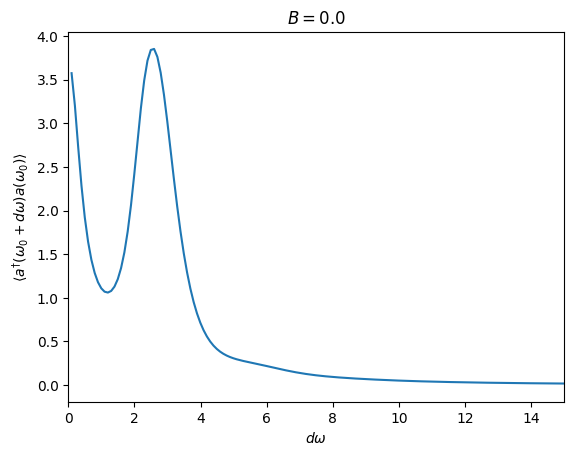

In [328]:
fig, ax = plt.subplots()
ax.plot(w, func)
plot_axis = plt.gca()
plot_axis.set_xlim([0,15])
plt.xlabel('$d\omega$')
plt.ylabel(r'$\langle a^{\dagger}(\omega_0 + d\omega) a(\omega_0) \rangle$')
plt.title(f'$B = {B}$')
plt.show()

# Finding the sensor's sensitivity

Rather than do calculations over and over again, you can just load raw data—it
saves quite a bit of time.

In [303]:
w = np.load('frequencies.npy')    
correlation_functions = np.load('correlation_functions.npy')
magnetic_fields = np.load('magnetic_fields.npy')

In [312]:
def calculate_derivative(functions, coordinates):
    dx = np.diff(coordinates)[0]
    dy = np.diff(functions, axis = 0)
    return dy / dx

In [416]:
dadB = calculate_derivative(correlation_functions, magnetic_fields)
dadw = calculate_derivative(correlation_functions, w)

max_dadB = [np.amax(dadB[i]) for i in range(0, len(dadB))]
max_dadw = [np.amax(dadw[i]) for i in range(0, len(dadw))]

In [427]:
d2adw2 = calculate_derivative(dadB, w)

In [429]:
np.shape(d2adw2)

(498, 500)

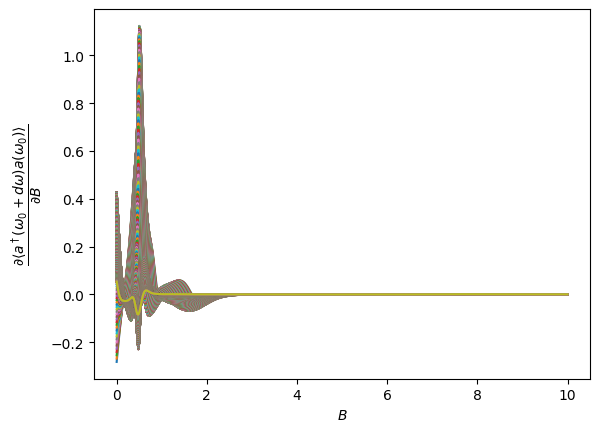

In [379]:
#plt.plot(magnetic_fields, dadB)
fig, ax = plt.subplots()
for i in range(0, len(dadB)):
    ax.plot(magnetic_fields, dadB[i])
#ax.plot(magnetic_fields, dadB[0])
#ax.plot(magnetic_fields, dadB[-1])
plt.xlabel('$B$')
plt.ylabel(r'$\dfrac{\partial \langle a^\dagger(\omega_0 + d\omega) a(\omega_0) \rangle}{\partial B}$')
plt.show()

In [359]:
maximums = [np.amax(dadB[i]) for i in range(0, len(dadB))]
minimums = [np.amin(dadB[i]) for i in range(0, len(dadB))]
means    = [np.mean(dadB[i]) for i in range(0, len(dadB))]

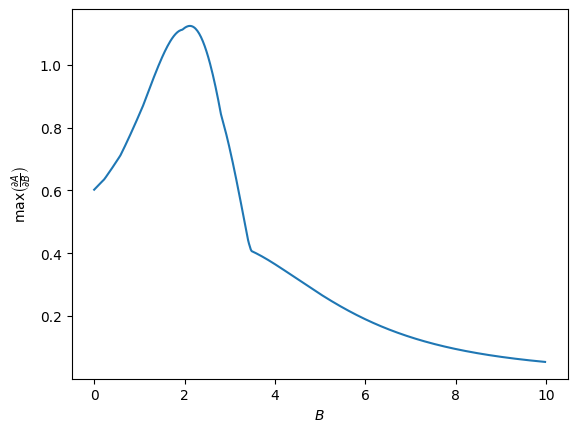

In [397]:
plt.plot(magnetic_fields[0:-1], maximums)
plt.xlabel(r'$B$')
plt.ylabel(r'$\text{max} \left( \frac{\partial A}{\partial B} \right)$')
plt.show()

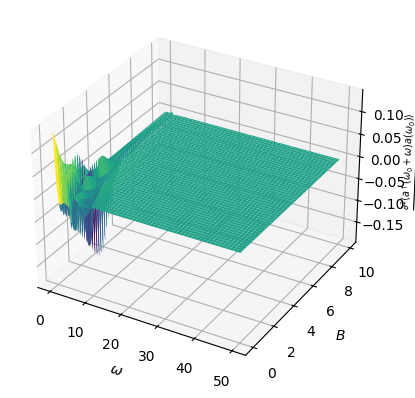

In [463]:
W, b = np.meshgrid(w, B)
fig = plt.figure()
ax  = plt.axes(projection = '3d')
ax.plot_surface(W[0:-2][0:-2], b[0:-4], d2adw2[:][0:-2], cmap='viridis', edgecolor='none')
ax.set_zlabel(r'$\frac{\partial^2 \langle a^\dagger(\omega_0 + \omega) a(\omega_0) \rangle}{\partial \omega \, \partial B}$')
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$B$')
plt.savefig('3dplot.pdf')
plt.show()